In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def f(x):
    y = x+0.4
    return np.exp(-0.1*y**2)*y
def g(x):
    return f(x)+np.random.rand(x.shape[0])*0.4-0.2

In [4]:
step = 0.2
Nx = 50
L = Nx*step
num_of_ghosts = 2
half = 20
sep = half*step

In [5]:
x = np.arange(0, L+2*num_of_ghosts*step, step)-num_of_ghosts*step
y = f(x)
z = g(x)

In [6]:
from scipy.ndimage import gaussian_filter
t = gaussian_filter(z, sigma=2)

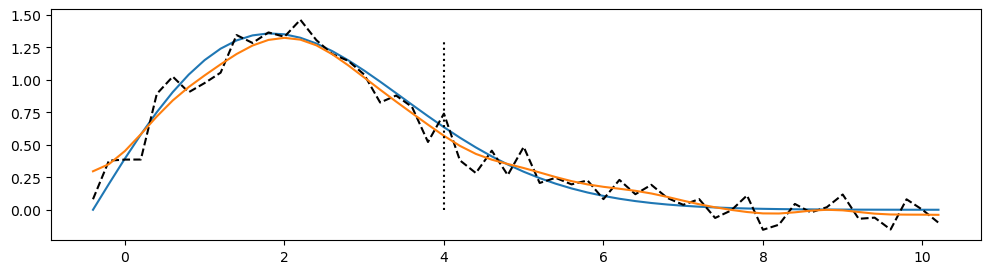

In [7]:
fig, ax = plt.subplots(figsize=(12, 3))

plt.plot(x, y)
plt.plot(x, z, 'k--')
plt.plot(x, t)
plt.plot([sep, sep], [0, 1.3], 'k:')

In [8]:
x1 = x[:half+2*num_of_ghosts]
x2 = x[half:]
# print(x, x1, x2)
y1 = z[:half+2*num_of_ghosts]
y2 = z[half:]

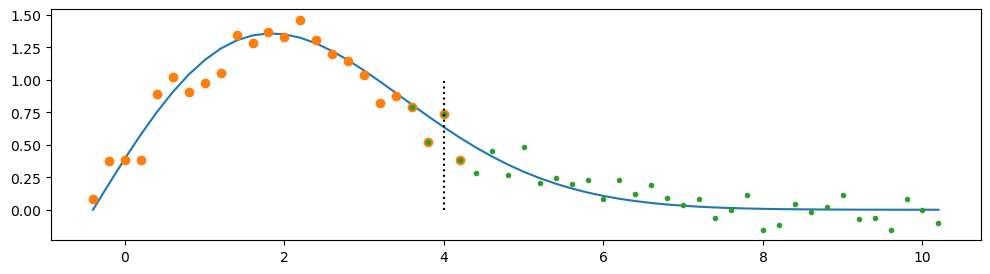

In [9]:
fig, ax = plt.subplots(figsize=(12, 3))

plt.plot(x, y)
plt.plot(x1, y1, 'o')
plt.plot(x2, y2, '.')
plt.plot([sep, sep], [0, 1], 'k:')

In [10]:
class Patch():
    def __init__(self, data, idx, num_of_ghosts=2):
        self.data = np.array(data)
        self.nx = self.data.shape[0]
        self.idx = np.array(idx)
    def __repr__(self):
        return """
        data : {0}
        idx  : {1}
        nx   = {2}""".format(self.data, self.idx, self.nx)

In [11]:
p1 = Patch(y1, x1)
p2 = Patch(y2, x2)
# print(p1, p2)

In [22]:
class Hierarchy():
    def __init__(self, patches):
        self.patches = patches
    def __repr__(self):
        return """
        p1 : {0}
        p2 : {1}
        """.format(self.patches[0], self.patches[1])

In [23]:
h = Hierarchy([p1, p2])

In [24]:
print(h)


        p1 : 
            data : [0.08105625 0.37804369 0.38576509 0.38630003 0.89084832 1.02355468
 0.90361692 0.97447679 1.05394405 1.34329411 1.2824403  1.36339278
 1.3300612  1.46066857 1.30451663 1.1970324  1.14501939 1.03940568
 0.82457256 0.87823039 0.79037873 0.52110863 0.73931172 0.38001575]
            idx  : [-0.4 -0.2  0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2
  2.4  2.6  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2]
            nx   = 24
        p2 : 
            data : [ 7.90378725e-01  5.21108626e-01  7.39311723e-01  3.80015755e-01
  2.82467589e-01  4.54158834e-01  2.66468578e-01  4.83313742e-01
  2.06081612e-01  2.45723947e-01  1.95300582e-01  2.25493630e-01
  8.17735695e-02  2.29734147e-01  1.19572296e-01  1.91976600e-01
  9.11446597e-02  3.81450405e-02  8.19762475e-02 -6.29608278e-02
 -5.52742501e-03  1.10199699e-01 -1.53821142e-01 -1.14781006e-01
  4.47613398e-02 -2.05188850e-02  1.95366709e-02  1.17376627e-01
 -6.93996917e-02 -6.05546287e-02 -1.51816394e